# ToC
use `[Another Cell](#another_cell)` to point to a cell containing a `<a id='another_cell'></a>`

[All-in-One df](#All-in-One-df)
***
[csky-set-up](#csky-set-up)
***
[grb-list](#grb-list)
- [good-run-list-check](#good-run-list-check)
- [t100-distribution](#t100-distribution)
- [Special-GRBs](#Special-GRBs)
- [angular and spatial separation](#angular-and-spatial-separation)
***
[healpix-map](#healpix-map)
***
[greco-datesets](#greco-datesets)
- [effective area](#effective-area)
- [event-rate](#event-rate)
- [angular error](#angular-error)
***
[time-windows](#time-windows)
***
[Analysis](#Analysis)
 - [background scan](#background-scan)
    - [background-illustration](#background-illustration) 
    - [background-TS-distribution](#background-TS-distribution)
 - [signal injection](#signal-injection)

In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook
import seaborn as sns

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
LOCATION = paths.LOCATION
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
if 0:
    stay_awake(180)

# All-in-One df
<a id='All-in-One-df'></a>

In [2]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_healpix_nside64_2268.pkl")

In [3]:
df.head()

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,decl_source,pos_error_source,fluence,redshift,t_center,hasHealpix,probs
0,GRB200529B,GRB200529504,337.200000,55.230000,3.506136,58998.503432,0.000539,0.000539,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,0.000005,NaN,58998.503701,True,"[-4.2069658304774985e-09, -4.227314275624824e-..."
1,GRB200529A,GRB200529039,238.763917,-11.073639,0.000233,58998.039294,0.001004,0.000984,0,Swift,Swift,Swift,0.000005,NaN,58998.039796,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,GRB200528A,GRB200528436,176.637458,58.192583,0.000194,58997.435683,0.000700,0.000655,0,Swift,Swift,Swift,0.000029,NaN,58997.436033,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,GRB200525A,GRB200525611,20.610000,-8.520000,4.536708,58994.611328,0.001081,0.001081,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,0.000009,NaN,58994.611869,True,"[3.3879127299320853e-09, 3.2096421093498023e-0..."
4,GRB200524A,GRB200524211,212.750000,60.966667,0.100000,58993.211115,0.000445,0.000437,0,IPN,IPN,IPN,0.000014,1.256,58993.211338,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
df.shape

(2268, 17)

In [5]:
# GBM-GRB examples
df.loc[df['grb_name'] =="GRB180423A"]

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,decl_source,pos_error_source,fluence,redshift,t_center,hasHealpix,probs
583,GRB180423A,GRB180423033,208.68,9.84,4.794662,58231.032586,0.000634,0.000634,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,0.000003,NaN,58231.032903,True,"[8.196013311400588e-13, 2.276715413254662e-13,..."


In [6]:
np.array([0.000634]) * 86400

array([54.7776])

In [7]:
# nonGBM-GRB examples
df.loc[df['grb_name'] == "GRB190415A"]

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,decl_source,pos_error_source,fluence,redshift,t_center,hasHealpix,probs
291,GRB190415A,GRB190415173,28.054167,20.266667,2.05,58588.173449,0.000662,0.000607,0,IPN,IPN,IPN,0.00006,NaN,58588.17378,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
np.array([0.000662]) * 86400

array([57.1968])

# Csky set up
<a id='csky-set-up'></a>

In [4]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
# bins_logenergy = np.linspace(min_log_e, 5, 30+1)
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory: use False





===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [5]:
conf = {
    'ana': ana,
    #### llh basics: csky.conf
    'space': 'ps', # ps/fitps/template/prior
    'time': 'transient', # utf/lc/transient
    'energy': 'customflux', # fit/customflux
    'flux': cy.hyp.PowerLawFlux(2.5),
    #### inj.py - prior has some duplications against space's prior
    'sig': 'transient', # ps/tw/lc/transient/template/prior
    'full_sky': True,
    'extended': True,
    'mp_cpus': 4,
    'cut_n_sigma': 3
    }

cy.CONF.update(conf)

In [6]:
ana[0].data.mjd.min(), ana[0].data.mjd.max()

(56043.42737937245, 58998.82365369969)

# GRB List
<a id='grb-list'></a>

## good run list check
<a id='good-run-list-check'></a>

In [12]:
si = np.searchsorted(ana[0].grl.start, df.mjd_start, side='right')
ei = np.searchsorted(ana[0].grl.stop, df.mjd_start+df.t100, side='left')
print(str(len(df[(si - ei) != 1])) + " GRBs have a (mjd_start, mjd_start+t100) overlapping with deadtime periods.")
good_run_mask = (si - ei) == 1

107 GRBs have a (mjd_start, mjd_start+t100) overlapping with deadtime periods.


## t100 distribution
<a id='t100-distribution'></a>

In [13]:
hl.hist(df.t100*86400.
         ,bins=np.r_[np.logspace(np.log10(0.001), np.log10(2.5), 20, endpoint=False), np.logspace(np.log10(2.5), np.log10(10000), 20)])

Hist(39 bins in [0.001,10000.0], with sum 2268.0, 10 empty bins, and 0 non-finite values)

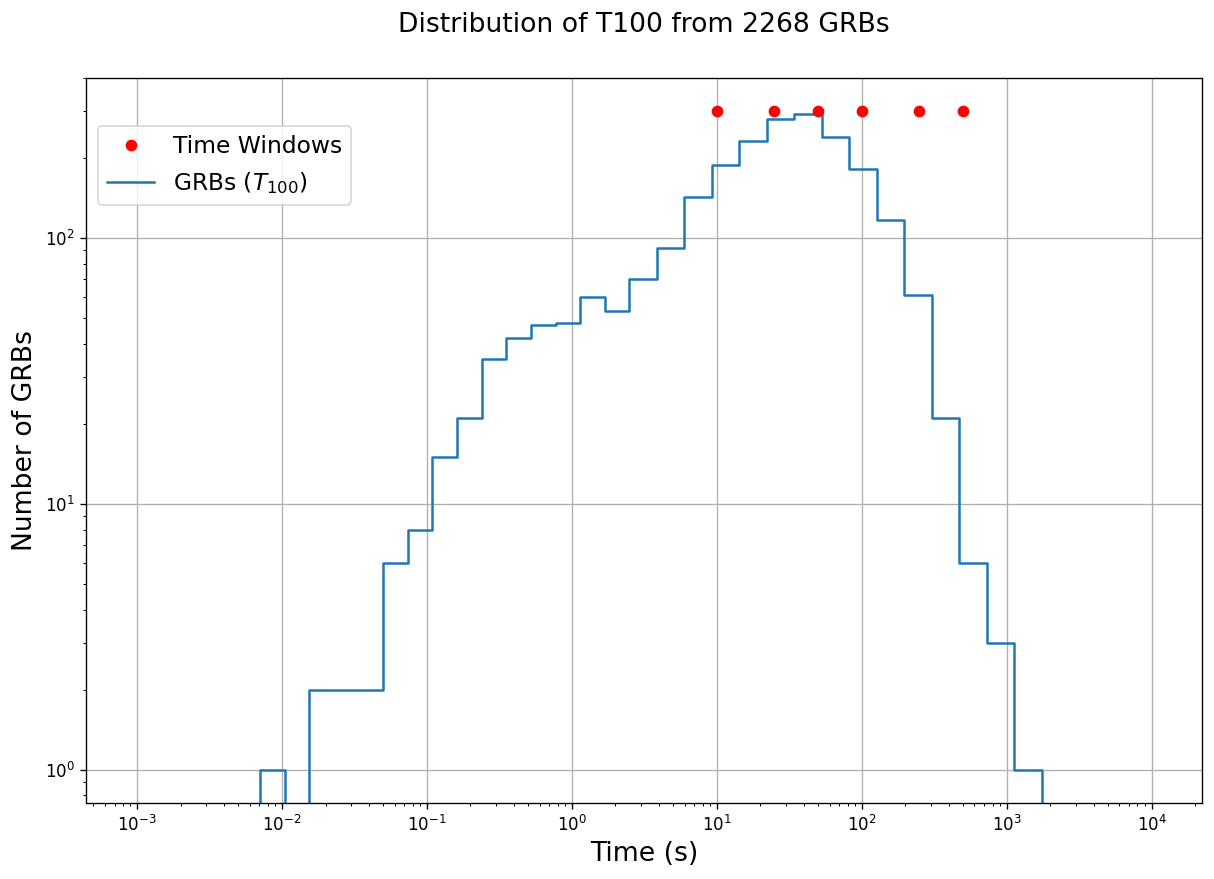

In [14]:
fig, ax = plt.subplots(figsize=(12,8), dpi=120)

h = hl.hist (df.t100*86400.
             ,bins=np.r_[
                 np.logspace(np.log10(0.001), np.log10(2.5), 20, endpoint=False), 
                 np.logspace(np.log10(2.5), np.log10(10000), 20)
             ])
hl.plot1d (ax, h, label=r'GRBs ($T_{100}$)')

ax.plot([10,25,50,100,250,500], np.ones(6)+300, 'ro', label="Time Windows")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_ylabel('Number of GRBs', fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.0, 0.95), fontsize=14)
ax.set_title('Distribution of T100 from {} GRBs'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()

## Special GRBs
<a id='Special-GRBs'></a>

In [27]:
# GBM-noMap-GRBs
gbm_nomap_mask = (df.gbm==1) & (~df.hasHealpix)                         ## Since 09/25/2021
df[gbm_nomap_mask].drop('probs', axis=1, inplace=False).head()          ## GBM-noMap-GRBs are discarded

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,decl_source,pos_error_source,fluence,redshift,t_center,hasHealpix


In [28]:
# nonGBM-noSU-GRBs
noSU = (df.pos_error_source.isna() | (df.pos_error_source=='circular'))
df.source_uncertainty[(~df.gbm) & noSU].shape

(69,)

In [29]:
# GBM-hasSU-GRBs, nonGBM-hasSU-GRBs
df[df.gbm & (~np.isnan(df.source_uncertainty))].shape[0], df[(~df.gbm) & (~noSU)].shape[0]

(1338, 861)

(<matplotlib.patches.Rectangle at 0x2aab0661a990>,
 (<matplotlib.patches.ConnectionPatch at 0x2aab06647d50>,
  <matplotlib.patches.ConnectionPatch at 0x2aab0664fe50>))

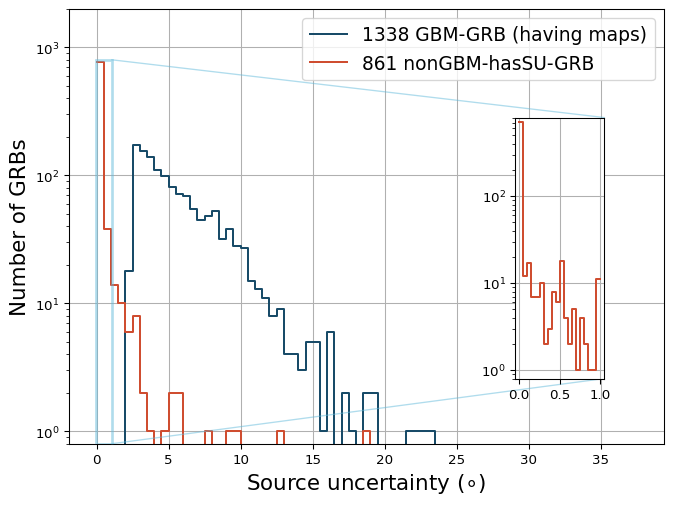

In [23]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)
h = hl.hist(df.source_uncertainty[df.gbm & (~np.isnan(df.source_uncertainty))], bins=np.r_[0:38:0.5])
hl.plot1d (ax, h, label=r'1338 GBM-GRB (having maps)', color='#184b68')

h = hl.hist(df.source_uncertainty[(~df.gbm) & (~noSU)], bins=np.r_[0:38:0.5])
hl.plot1d (ax, h, label=r'861 nonGBM-hasSU-GRB', color='#cf4d30')

ax.set_ylim(8e-1, 38)
ax.set_ylim(0.8, 2e3)
ax.set_yscale('log')
ax.set_xlabel('Source uncertainty $(\circ)$', fontsize=16)
ax.set_ylabel('Number of GRBs', fontsize=16)
ax.grid(True)
ax.legend(loc='upper right', fontsize=14)

axins = ax.inset_axes([0.75, 0.15, 0.15, 0.6])
h = hl.hist(df.source_uncertainty[(~df.gbm) & (~np.isnan(df.source_uncertainty))], bins=20, range=(0,1))
hl.plot1d (axins, h, label=r'<1 degreee nonGBM-GRB', color='#cf4d30')
axins.set_yscale('log')
axins.set_ylim(0.8, 1.2)
axins.set_ylim(0.8, 0.8e3)
axins.grid(True)
axins.set_xticks(np.r_[0:1.1:0.5])

ax.indicate_inset_zoom(axins, edgecolor="#62badb", linewidth=2)

In [20]:
# nonGBM-humanSU-GRBs
df[df.pos_error_source=='circular'].shape[0]

17

In [30]:
def estimate_1sigma_error_radius(m):
    ratio = np.sum(m > isf_healpix(m, 0.39)) / hp.get_map_size(m)
    solid_area = ratio * 4 * np.pi
    return np.rad2deg(np.sqrt(solid_area))

ipn52 = df[(df.ra_source=='GCN_circulars,IPN Triangulation') & df.hasHealpix]
human17 = df[df.pos_error_source=='circular']
ipn52_errs = np.array([estimate_1sigma_error_radius(x) for x in ipn52.probs])
human17_errs = human17.source_uncertainty.values

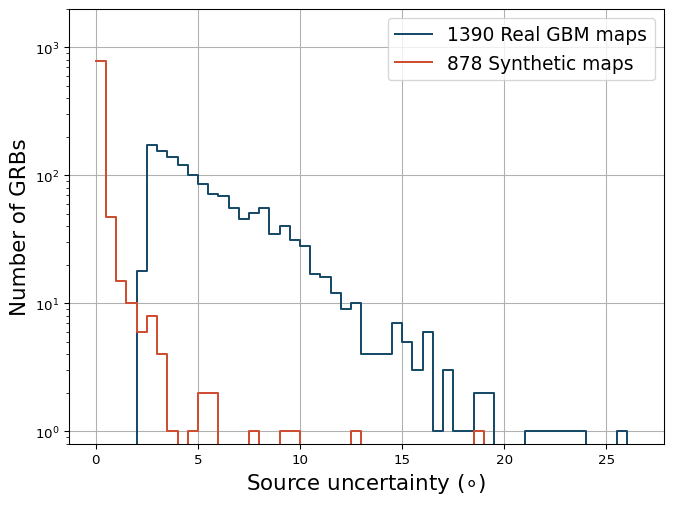

In [36]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)
h = hl.hist(np.append(df.source_uncertainty[df.gbm & (~np.isnan(df.source_uncertainty))].values, ipn52_errs), bins=np.r_[0:27:0.5])
hl.plot1d (ax, h, label=r'1390 Real GBM maps', color='#184b68')

h = hl.hist(np.append(df.source_uncertainty[(~df.gbm) & (~noSU)].values, human17_errs), bins=np.r_[0:20:0.5])
hl.plot1d (ax, h, label=r'878 Synthetic maps', color='#cf4d30')

ax.set_ylim(8e-1, 38)
ax.set_ylim(0.8, 2e3)
ax.set_yscale('log')
ax.set_xlabel('Source uncertainty $(\circ)$', fontsize=16)
ax.set_ylabel('Number of GRBs', fontsize=16)
ax.grid(True)
ax.legend(loc='upper right', fontsize=14)

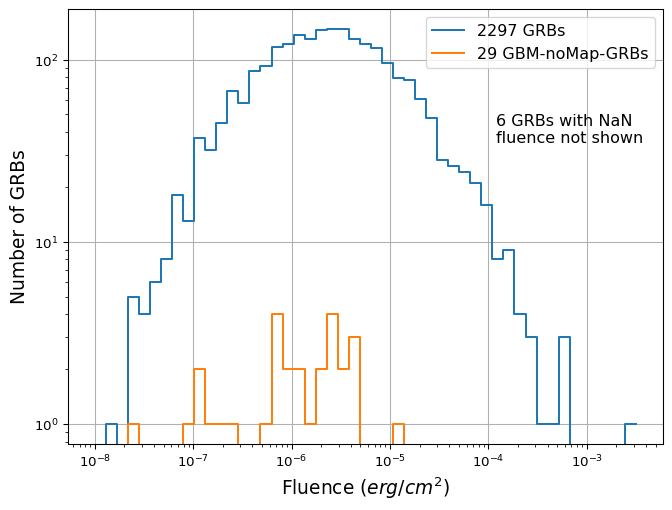

In [50]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)
h = hl.hist(df.fluence, bins=np.logspace(-8,-2.5,50))
hl.plot1d (ax, h, label=r'2297 GRBs')

h = hl.hist(df.fluence[gbm_nomap_mask], bins=np.logspace(-8,-2.5,50))
hl.plot1d (ax, h, label=r'29 GBM-noMap-GRBs')

ax.text(1.2e-4, 35, "6 GRBs with NaN\nfluence not shown", fontsize=12)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fluence $(erg/cm^2)$', fontsize=14)
ax.set_ylabel('Number of GRBs', fontsize=14)
ax.grid(True)
ax.legend(fontsize=12, loc='upper right')

## angular and spatial separation
<a id='angular-and-spatial-separation'></a>

In [9]:
"""
grb_pairs = []
mjd_separation = []
angular_separation = []
with time('get separation'):
    for i in df.index[:]:
        if i % 10 == 0: print("i: ", i)
        for j in df.index[i+1:]:
            grb_pair = set([df.grb_name[i], df.grb_name[j]])
            mjd_diff = abs(df['t_center'][i] - df['t_center'][j])
            ang_diff = cy.coord.delta_angle(
                np.deg2rad(df.dec[i])
                , np.deg2rad(df.ra[i])
                , np.deg2rad(df.dec[j])
                , np.deg2rad(df.ra[j])
                , latlon=True)
            grb_pairs.append(grb_pair)
            mjd_separation.append(mjd_diff)
            angular_separation.append(np.rad2deg(ang_diff))
grb_pairs = np.array(grb_pairs)
mjd_separation = np.array(mjd_separation)
angular_separation = np.array(angular_separation)
separation_df = pd.DataFrame({
    'grb_pair': grb_pairs, 
    'mjd_diff': mjd_separation, 
    'angular_diff': angular_separation
})
separation_df.to_pickle(DATA_DIR+"/plot/Proximities.pkl")
"""

'\ngrb_pairs = []\nmjd_separation = []\nangular_separation = []\nwith time(\'get separation\'):\n    for i in df.index[:]:\n        if i % 10 == 0: print("i: ", i)\n        for j in df.index[i+1:]:\n            grb_pair = set([df.grb_name[i], df.grb_name[j]])\n            mjd_diff = abs(df[\'t_center\'][i] - df[\'t_center\'][j])\n            ang_diff = cy.coord.delta_angle(\n                np.deg2rad(df.dec[i])\n                , np.deg2rad(df.ra[i])\n                , np.deg2rad(df.dec[j])\n                , np.deg2rad(df.ra[j])\n                , latlon=True)\n            grb_pairs.append(grb_pair)\n            mjd_separation.append(mjd_diff)\n            angular_separation.append(np.rad2deg(ang_diff))\ngrb_pairs = np.array(grb_pairs)\nmjd_separation = np.array(mjd_separation)\nangular_separation = np.array(angular_separation)\nseparation_df = pd.DataFrame({\n    \'grb_pair\': grb_pairs, \n    \'mjd_diff\': mjd_separation, \n    \'angular_diff\': angular_separation\n})\nseparation_d

In [10]:
## works on HIVE
separation_df = pd.read_pickle(DATA_DIR+"/plot/Proximities.pkl")
separation_df['mjd_diff_seconds'] = separation_df["mjd_diff"] * 86400.
separation_df.head()

,grb_pair,mjd_diff,angular_diff,mjd_diff_seconds
0,"{GRB200529B, GRB200529A}",0.463906,103.879587,40081.436999
1,"{GRB200528A, GRB200529B}",1.067668,65.503296,92246.550000
2,"{GRB200525A, GRB200529B}",3.891832,73.261031,336254.313999
3,"{GRB200524A, GRB200529B}",5.292363,55.829455,457260.201500
4,"{GRB200529B, GRB200522B}",6.853080,132.408220,592106.116500


In [11]:
separation_df[separation_df.mjd_diff_seconds < 500]

,grb_pair,mjd_diff,angular_diff,mjd_diff_seconds
493037,"{GRB190630B, GRB190630A}",0.005410,170.362686,467.391501
648998,"{GRB190326B, GRB190326A}",0.002313,48.863371,199.857499
1066534,"{GRB180620A, GRB180620C}",0.004249,123.727640,367.082000
1896237,"{GRB160625A, GRB160625B}",0.003226,112.754875,278.745499
2004198,"{GRB160216A, GRB160216B}",0.001647,122.135791,142.287500
2395843,"{GRB140619D, GRB140619A}",0.003815,61.198196,329.614000


In [20]:
df.grb_name

0       GRB200529B
1       GRB200529A
2       GRB200528A
3       GRB200525A
4       GRB200524A
           ...    
2263    GRB120429B
2264    GRB120429A
2265    GRB120427B
2266    GRB120427A
2267    GRB120426B
Name: grb_name, Length: 2268, dtype: object

In [21]:
df[df.grb_name.isin(["GRB190326B", "GRB190326A", "GRB140619D", "GRB140619A"])]

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,decl_source,pos_error_source,fluence,redshift,t_center,hasHealpix,probs
307,GRB190326B,GRB190326314,264.210000,68.320000,2.558593,58568.313646,6.755671e-04,6.459375e-04,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,1.451600e-05,NaN,58568.313984,True,"[4.448142818714851e-06, 4.938847838562695e-06,..."
308,GRB190326A,None,341.652000,39.914000,0.012426,58568.316296,9.259259e-07,9.259259e-07,0,Swift,Swift,Swift,6.300000e-08,NaN,58568.316297,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1676,GRB140619D,GRB140619490,304.960000,-39.180000,6.344131,56827.490293,5.185185e-06,5.185185e-06,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,2.102800e-07,NaN,56827.490296,True,"[-1.957575379737794e-09, -1.7961024058434942e-..."
1678,GRB140619A,None,27.108958,-39.259056,0.000129,56827.485127,2.707176e-03,2.707176e-03,0,Swift,Swift,Swift,2.100000e-05,NaN,56827.486481,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
df[df.grb_name in ["GRB190326B", "GRB190326A", "GRB140619D", "GRB140619A"]]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

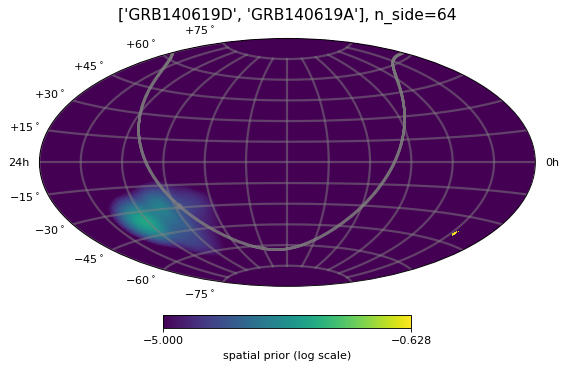

0.448
233.89999999999998


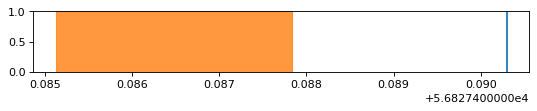

In [23]:
# close_grb_pair=["GRB190630B", "GRB190630A"]
# close_grb_pair=["GRB190326B", "GRB190326A"]
# close_grb_pair=["GRB180620A", "GRB180620C"]
# close_grb_pair=["GRB160625A", "GRB160625B"]
# close_grb_pair=["GRB160216A", "GRB160216B"]
close_grb_pair=["GRB140619D", "GRB140619A"]

fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))

healpix = np.maximum(0, df[df.grb_name==close_grb_pair[0]]['probs'].values[0])
healpix = np.maximum(healpix, df[df.grb_name==close_grb_pair[1]]['probs'].values[0])
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-5)), n_ticks=2)

kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale)')
ax.set_title(f"{close_grb_pair}, n_side=64", fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()

fig, ax = plt.subplots (figsize=(8,1), dpi=80)
close_grb_df = df.loc[df.grb_name.isin(close_grb_pair)].reset_index(drop=True)
for i, grb_row in close_grb_df.iterrows():
    print(grb_row['t100']*86400)
    ax.axvspan(grb_row['mjd_start'], grb_row['mjd_start']+grb_row['t100'], 
           color=sns.color_palette()[i], alpha=0.8)
    
plt.show()

In [22]:
close_grb_df

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,decl_source,pos_error_source,fluence,redshift,t_center,hasHealpix,probs
0,GRB140619D,GRB140619490,304.960000,-39.180000,6.344131,56827.490293,0.000005,0.000005,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,2.102800e-07,NaN,56827.490296,True,"[-1.957575379737794e-09, -1.7961024058434942e-..."
1,GRB140619A,None,27.108958,-39.259056,0.000129,56827.485127,0.002707,0.002707,0,Swift,Swift,Swift,2.100000e-05,NaN,56827.486481,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


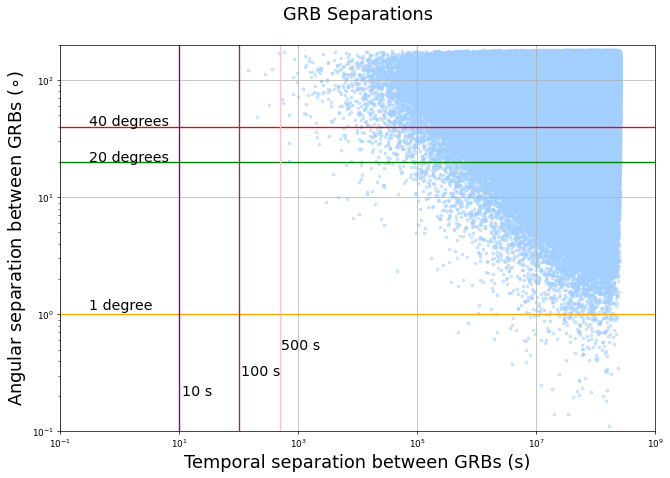

In [10]:
fig, ax = plt.subplots(figsize=(12,8), dpi=64)

ax.scatter(separation_df['mjd_diff_seconds']
           , separation_df['angular_diff']
           , c="#a2cffe"
           , marker='.'
           , alpha = 0.5)

ax.axhline(1,color = 'orange')
ax.text(0.3, 1.1, '1 degree', fontsize=16)
ax.axhline(20,color = 'green')
ax.text(0.3, 20.1, '20 degrees', fontsize=16)
ax.axhline(40,color = 'red')
ax.text(0.3, 41, '40 degrees', fontsize=16)

ax.axvline(10, color = 'purple')
ax.text(11, .2, '10 s', fontsize=16)
ax.axvline(100, color = 'brown')
ax.text(110, .3, '100 s', fontsize=16)
ax.axvline(500, color = 'pink')
ax.text(510, .5, '500 s', fontsize=16)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Temporal separation between GRBs (s)', fontsize=20)
ax.set_ylabel(r'Angular separation between GRBs ($\circ$)', fontsize=20)
ax.set_xlim(1e-1,1e9)
ax.set_ylim(1e-1,2e2)
ax.grid(True)
# ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.0, 0.95), fontsize=16)
ax.set_title('GRB Separations', fontsize=20, y=1.05)
plt.show()

# Healpix Map
<a id='healpix-map'></a>

## real healpix example: GRB180423A

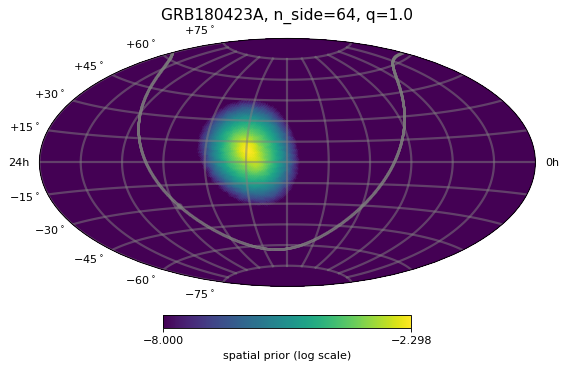

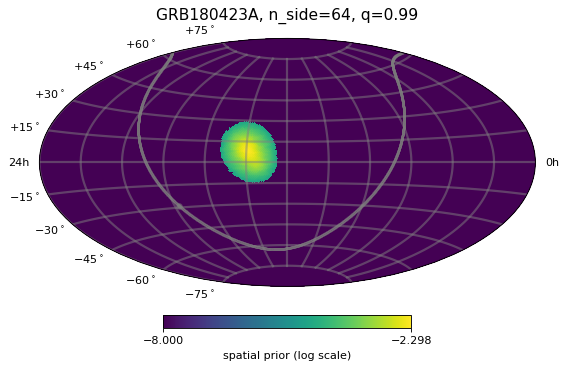

In [10]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
for q in [1.0, 0.99]: #, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-8)), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'spatial prior (log scale)')
    ax.set_title("GRB180423A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()



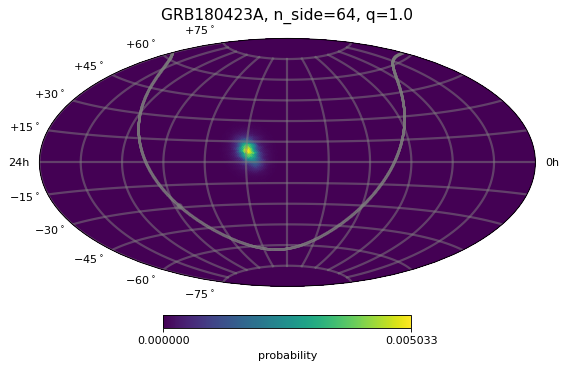

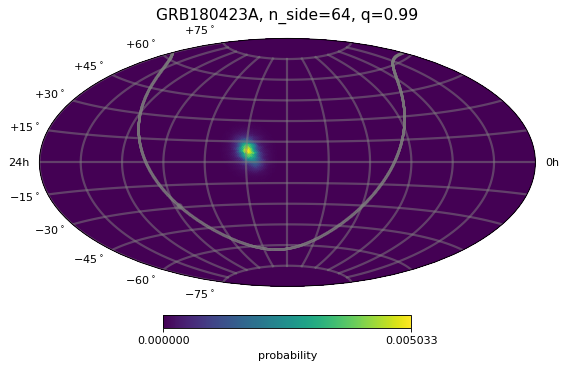

In [15]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
for q in [1.0, 0.99]: #, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, healpix, 1e-15, n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'probability')
    ax.set_title("GRB180423A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()



## IPN-GBM GRB healpix example: GRB170527A

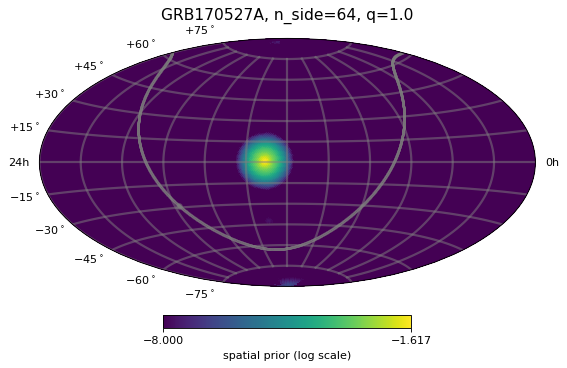

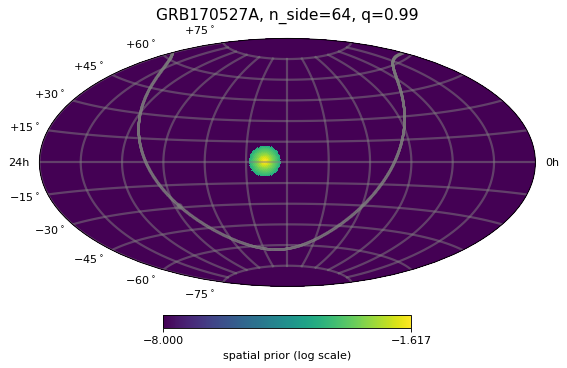

In [11]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB170527A"))
for q in [1.0, 0.99]: #, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-8)), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'spatial prior (log scale)')
    ax.set_title("GRB170527A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()


# fake GRB: GRB150716A

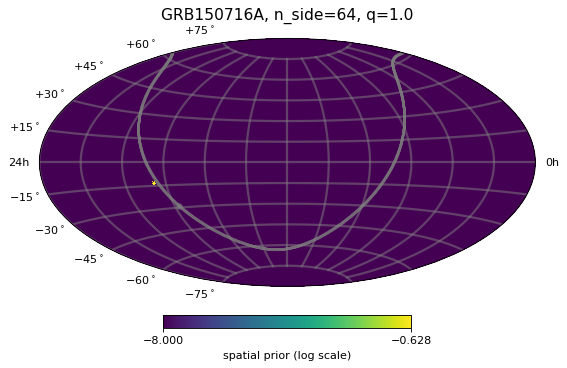

In [13]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB150716A"))
for q in [1.0]: #, 0.99, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-8)), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'spatial prior (log scale)')
    ax.set_title("GRB150716A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()



# GRECO datasets
<a id='greco-datesets'></a>

## Effective Area
<a id='effective-area'></a>

In [6]:
print("\n===== Special GRECO ana setting only for Effective Area plotting =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(0, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
greco_ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory: use False



===== Special GRECO ana setting only for Effective Area plotting =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [7]:
gfu_ana = cy.get_analysis(
        cy.selections.Repository("/storage/hive/project/phy-taboada/cchen641/icecube/data/analyses"), 
        'version-002-p06',
        cy.selections.GFUDataSpecs.gfu_4yr,
    )

Setting up Analysis for:
GFU_2015_2018
Setting up GFU_2015_2018...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/IC86_2011_MC.npy ...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/IC86_2015_data.npy ...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/IC86_2016_data.npy ...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/IC86_2017_data.npy ...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/IC86_2018_data.npy ...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/GRL/IC86_2015_data.npy ...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/GRL/IC86_2016_data.npy ...
Reading /storage/hive/project/phy-taboada/cchen641/icecube/data/analyses/gfu/version-002-p06/GRL/IC86_2017_data.npy

In [54]:
def effective_area(mc, #=ana[0].sig, 
                   decs=np.radians(np.asarray([[-90., -30.], [-30., 30.], [30., 90.]])), 
                   E_bins=np.logspace(0., 9., 61), save_npy=False, **kwargs):
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        fig, ax = plt.subplots()
    if 'linestyles' in kwargs:
        linestyles = kwargs['linestyles']
    else:
        linestyles = np.repeat('solid', decs.shape[0])
        
    mc = mc[(mc['true_energy'] >= E_bins[0]) & (mc['true_energy'] <= E_bins[-1])]
    sin_decs = np.sin(decs)
    logE_bins = np.log10(E_bins)
    dlog_E = np.diff(logE_bins)
    hs = []
    for ii, (low_dec, high_dec) in enumerate(sin_decs):
        d_omega = 2.*np.pi*np.abs(high_dec - low_dec)
        dec_msk = np.sin(mc['true_dec']) > low_dec
        dec_msk *= np.sin(mc['true_dec']) < high_dec
        mc_cut = mc[dec_msk]
        weights = mc_cut['oneweight'] / (1e4 * mc_cut['true_energy'] * dlog_E[np.digitize(
            np.log10(mc_cut['true_energy']), bins = logE_bins) -1] * d_omega * np.log(10.))
        lab = f"{np.degrees(np.arcsin(low_dec)):.0f}" + r'$^{\circ} <  \delta < \; $' \
                        + f"{np.degrees(np.arcsin(high_dec)):.0f}" + r'$^{\circ}$' \
                        + kwargs.get('label_text', "")
#         h = hl.hist(mc_cut['true_energy'], bins = E_bins, weights = weights)
#         hs.append(h)
        h = hl.hist_slide(
            10,
            mc_cut['true_energy'],
            # E^-2 weighting
            weights=weights,
            bins=E_bins
        )
        hs.append(h.contain(0, .5))
        ###### save as npy for itaboada
        if save_npy:
            hl.save(h, 
                    f"/storage/home/hhive1/cchen641/icecube/greco_grb/notebooks/{np.degrees(np.arcsin(low_dec)):.0f}_{np.degrees(np.arcsin(high_dec)):.0f}.npy")
        ##############################
        hl.plot1d(ax, h, linewidth = 2., label=lab, linestyle=linestyles[ii])

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(4e-1, 3e3)
    ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=20)
    ax.set_ylabel('$A_{\mathrm{eff}}$ (m$^{2}$)', fontsize=20)
    ax.legend(loc=2, fontsize=16, frameon=False)
    return hs

In [55]:
tmp_style = {
    'text.usetex' : False,
    'mathtext.rm' : 'Times New Roman',
    'mathtext.it' : 'Times New Roman:italic',
    'mathtext.bf' : 'Times New Roman:bold',
    'mathtext.fontset': 'stix',
    'xtick.labelsize' : 20,
    'ytick.labelsize' : 20,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.minor.size' : 3,
    'ytick.minor.size' : 3,
    'axes.labelsize' : 18,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.right' : True,
    'xtick.top' : True,
    'axes.grid' : True,
    'axes.grid.which' : 'major',
    'axes.linewidth': 1.5,
    'grid.color' : 'lightgrey',
    'grid.alpha' : 0.4,
    'grid.linewidth' : 0.75,
    'lines.linewidth' : 1.5,
    'font.size' : 16,
    'image.cmap': 'PuBu',
}

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested

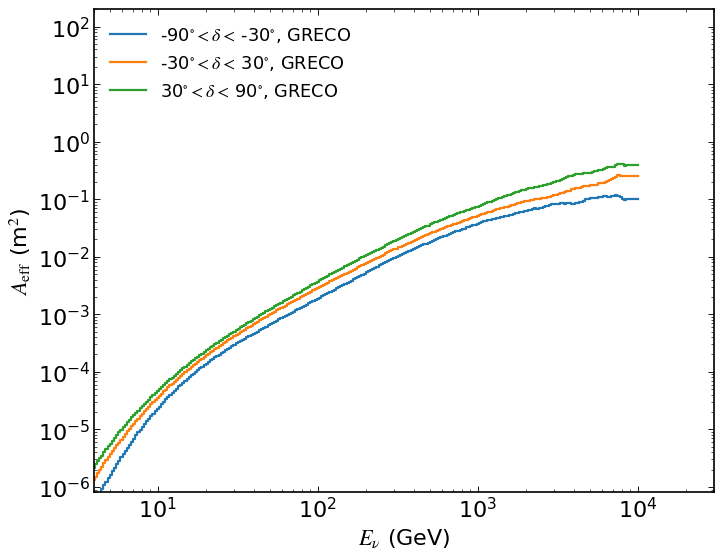

In [56]:
with mpl.rc_context(tmp_style):
    fig, ax = plt.subplots(figsize=(10,8), dpi=80)
    mc_greco = greco_ana[0].sig
    # mc_greco = ana[0].sig[(ana[0].sig.true_energy > 10) & (ana[0].sig.true_energy < 10000)]
    effective_area(mc=mc_greco, ax=ax, 
                   E_bins=np.logspace(0., 4., 31), 
                   save_npy=True,
                   label_text=", GRECO", linestyles=['solid', 'solid', 'solid'])
    mc_gfu = gfu_ana[0].sig
#     effective_area(mc=mc_gfu, ax=ax, 
#                    E_bins=np.logspace(2., 9., 31), 
#                    label_text=", GFU", linestyles=['dashed', 'dashed', 'dashed'])
    ax.set_xlim(4e0, 3e4)
    ax.set_ylim(0.8e-6, 2e2)
    locmajy = mpl.ticker.LogLocator(base=10,numticks=100) 
    ax.yaxis.set_major_locator(locmajy)
    locminy = mpl.ticker.LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100)
    ax.yaxis.set_minor_locator(locminy)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.grid(False)

In [58]:
np.load("-30_30.npy",allow_pickle=True)

array([list([array([1.00000000e+00, 1.18394992e+00, 1.22086225e+00, 1.25892541e+00,
              1.29817528e+00, 1.33864884e+00, 1.38038426e+00, 1.42342088e+00,
              1.46779927e+00, 1.51356125e+00, 1.56074996e+00, 1.60940989e+00,
              1.65958691e+00, 1.71132830e+00, 1.76468286e+00, 1.81970086e+00,
              1.87643417e+00, 1.93493628e+00, 1.99526231e+00, 2.05746916e+00,
              2.12161544e+00, 2.18776162e+00, 2.25597007e+00, 2.32630507e+00,
              2.39883292e+00, 2.47362199e+00, 2.55074278e+00, 2.63026799e+00,
              2.71227258e+00, 2.79683385e+00, 2.88403150e+00, 2.97394775e+00,
              3.06666733e+00, 3.16227766e+00, 3.26086886e+00, 3.36253386e+00,
              3.46736850e+00, 3.57547160e+00, 3.68694506e+00, 3.80189396e+00,
              3.92042666e+00, 4.04265487e+00, 4.16869383e+00, 4.29866235e+00,
              4.43268292e+00, 4.57088190e+00, 4.71338954e+00, 4.86034018e+00,
              5.01187234e+00, 5.16812886e+00, 5.32925703e+

In [6]:
def effective_area_in_dec(mc, #=ana[0].sig, 
                   decs=np.radians(np.array([-90., -30.])), 
                   E_bins=np.logspace(0., 9., 61), **kwargs):
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        fig, ax = plt.subplots()
    Ns = kwargs.get('Ns', 10)
    linestyle = kwargs.get('linestyle', 'solid')
    color = kwargs.get('color', '#184b68')
        
    mc = mc[(mc['true_energy'] >= E_bins[0]) & (mc['true_energy'] <= E_bins[-1])]
    sin_decs = np.sin(decs)
    logE_bins = np.log10(E_bins)
    dlog_E = np.diff(logE_bins)
    hs = []
    low_dec, high_dec = sin_decs[0], sin_decs[-1]
    d_omega = 2.*np.pi*np.abs(high_dec - low_dec)
                          
    dec_msk = np.sin(mc['true_dec']) > low_dec
    dec_msk *= np.sin(mc['true_dec']) < high_dec
    mc_cut = mc[dec_msk]
    weights = mc_cut['oneweight'] / (1e4 * mc_cut['true_energy'] * dlog_E[np.digitize(
        np.log10(mc_cut['true_energy']), bins = logE_bins) -1] * d_omega * np.log(10.))
    lab = f"{np.degrees(np.arcsin(low_dec)):.0f}" + r'$^{\circ} <  \delta < \; $' \
                    + f"{np.degrees(np.arcsin(high_dec)):.0f}" + r'$^{\circ}$' \
                    + kwargs.get('label_text', "")
#         h = hl.hist(mc_cut['true_energy'], bins = E_bins, weights = weights)
#         hs.append(h)
    h = hl.hist_slide(
        Ns=Ns,
        data=mc_cut['true_energy'],
        # E^-2 weighting
        weights=weights,
        bins=E_bins
    )
    hs.append(h.contain(0, .5))
    hl.plot1d(ax, h, linewidth = 2., label=lab, linestyle=linestyle, color=color, drawstyle='steps-mid')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(4e-1, 3e3)
    ax.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=20)
    ax.set_ylabel('$A_{\mathrm{eff}}$ (m$^{2}$)', fontsize=20)
    ax.legend(loc=2, fontsize=16, frameon=False)
    return hs

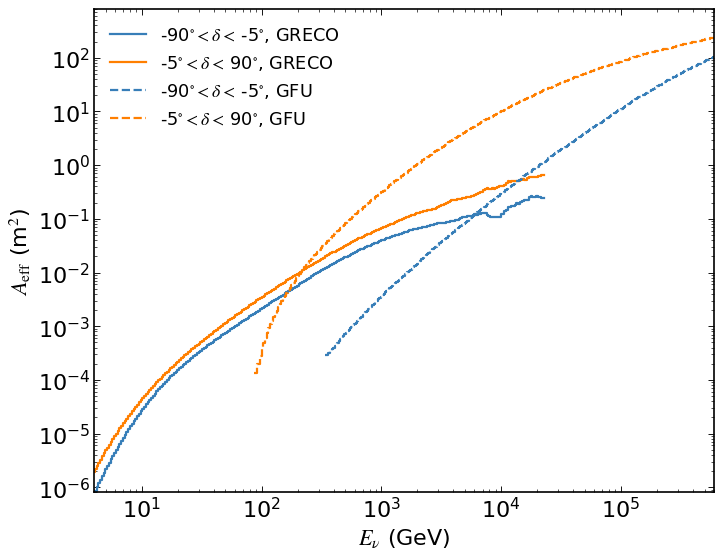

In [9]:
with mpl.rc_context(tmp_style):
    fig, ax = plt.subplots(figsize=(10,8), dpi=80)
    mc_greco = greco_ana[0].sig
    # mc_greco = ana[0].sig[(ana[0].sig.true_energy > 10) & (ana[0].sig.true_energy < 10000)]
    effective_area_in_dec(mc=mc_greco, ax=ax, 
                    decs=np.radians(np.array([-90., -5.])),
                   E_bins=np.logspace(0., 4.4, 31), 
                   label_text=", GRECO", Ns=10, linestyle='solid', color='#377eb8')
    effective_area_in_dec(mc=mc_greco, ax=ax, 
                    decs=np.radians(np.array([-5., 90.])),
                   E_bins=np.logspace(0., 4.4, 31), 
                   label_text=", GRECO", Ns=10, linestyle='solid', color='#ff7f00')
    mc_gfu = gfu_ana[0].sig
    effective_area_in_dec(mc=mc_gfu, ax=ax, 
                   decs=np.radians(np.array([-90., -5.])),
                   E_bins=np.logspace(2.5, 6, 31),#np.logspace(3.25, 4.6, 4), 
                   label_text=", GFU", Ns=10, linestyle='dashed', color='#377eb8')
    effective_area_in_dec(mc=mc_gfu, ax=ax, 
                   decs=np.radians(np.array([-5., 90.])),
                   E_bins=np.logspace(1.9, 6., 31), 
                   label_text=", GFU", linestyle='dashed', color='#ff7f00')
    ax.set_xlim(4e0,6e5)
    ax.set_ylim(0.8e-6, 8e2)
    locmajy = mpl.ticker.LogLocator(base=10,numticks=100) 
    ax.yaxis.set_major_locator(locmajy)
    locminy = mpl.ticker.LogLocator(base=10,subs=np.arange(2, 10) * .1,numticks=100)
    ax.yaxis.set_minor_locator(locminy)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.grid(False)

In [136]:
np.log10(8e5),10**5.5

(5.903089986991944, 316227.7660168379)

## Event rate
<a id='event-rate'></a>

In [28]:
greco_ana[0].data.energy.size, ana[0].data.energy.size

(1116537, 1010151)

In [24]:
greco_ana[0].data.energy.size / (np.sum(ana[0].grl.livetime)*0.001 * 86400. )

4.607932049722197

In [16]:
1010151 / (np.sum(ana[0].grl.livetime)*0.001 * 86400. )

4.168878566459442

In [26]:
np.sum(ana[0].grl.livetime) / 365

7.68352389534717

In [18]:
def get_event_rate_plot(grl, bin_width=7., **kwargs):
    """
    Plot TS distribution(s) and produce one plot
    
    Parameters
    ----------
    grl : csky.utils.Arrays
        e.g.: ana[0].grl
    
    bin_width : float
        interval length in days
        
    Returns
    -------
    N/A
    
    See also
    -------
    N/A
    """
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        fig, ax = plt.subplots()
        
    rates = grl.events / (0.001 * 86400. * grl.livetime)
    mjds = (grl.start + grl.stop) / 2
    h = hl.hist((mjds, rates), 
            bins=(np.r_[grl.start[0]:grl.stop[-1]+bin_width:bin_width], 100), 
            range=((56000,59040), (1,8)))
    h = h.normalize(1).to_finite()
    h = h.contain_project(1, .5)
    hl.plot1d(ax, h, errorbands=True, drawstyle='default', color='#004466', label="IC86")
#     ax.hlines(y=np.nanmean(h.values),  xmin=grl.start[0], xmax=grl.stop[-1], color='#d06050', label="Mean rate")
    ax.hlines(y=np.nanmedian(h.values),  xmin=grl.start[0], xmax=grl.stop[-1], color='#d06050', label="Median rate")
    
    ax.set_xlim(grl.start[0], grl.stop[-1])
    ax.set_ylim(3.2, 6.0)
    ax.set_ylabel('Rate (mHz)', fontsize = 20)
    ax.set_xlabel('Time (MJD)', fontsize = 20)
    ax.legend(loc=2, fontsize=14, frameon=True)
    return rates

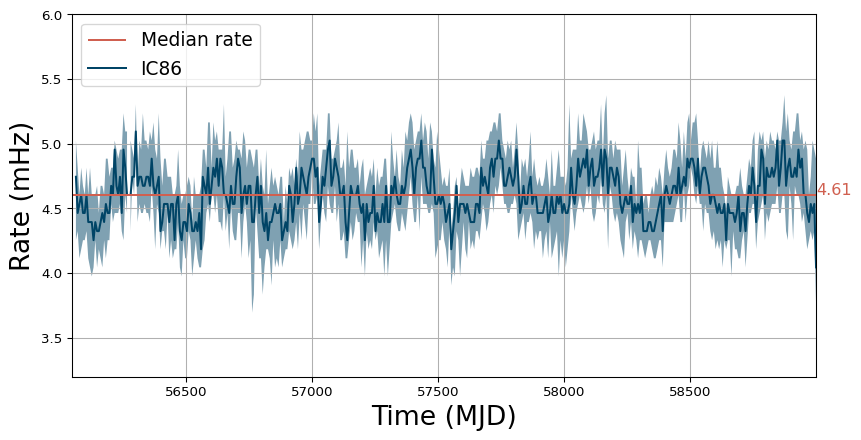

In [19]:
fig, ax = plt.subplots(figsize=(10,5), dpi=96)
rates = get_event_rate_plot(ana[0].grl[ana[0].grl.livetime > 0.3], ax=ax)
ax.text(x=59000,y=4.61, s="4.61",color='#d06050', fontsize = 12)
ax.grid()

In [20]:
np.mean(rates), np.median(rates)

(4.601128136429872, 4.6150075768869705)

In [21]:
ana[0].grl

Arrays(10522 items | columns: events, livetime, run, start, stop)

In [22]:
ana[0].grl[ana[0].grl.livetime > 0.3]

Arrays(7948 items | columns: events, livetime, run, start, stop)

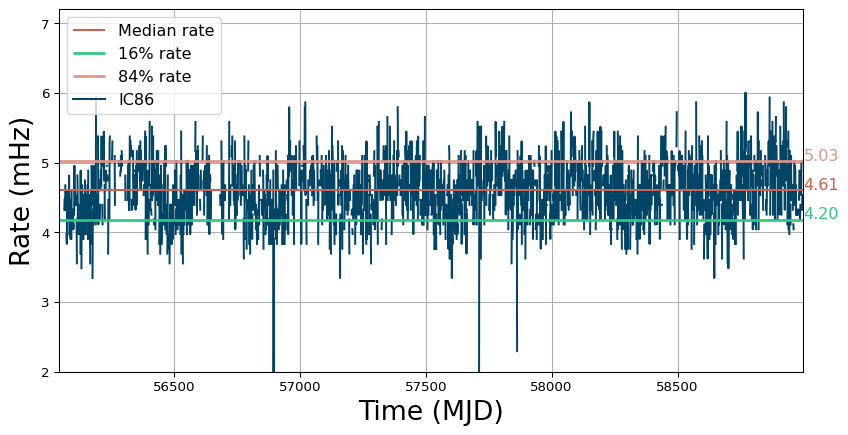

In [23]:
fig, ax = plt.subplots(figsize=(10,5), dpi=96)
rates = get_event_rate_plot(ana[0].grl[ana[0].grl.livetime > 0.3][0:10522:4], bin_width=1., ax=ax)
ax.set_ylim(2, 7.2)
ax.hlines(y=np.percentile(rates, 16),  xmin=56000, xmax=60000, color='#2aca80', label="16% rate", linewidth=2)
ax.hlines(y=np.percentile(rates, 84),  xmin=56000, xmax=60000, color='#dd9388', label="84% rate", linewidth=2)
ax.legend(loc=2, fontsize=12, frameon=True)
ax.text(x=59000,y=4.61, s="4.61",color='#d06050', fontsize = 12)
ax.text(x=59000,y=4.20, s="4.20",color='#2aca80', fontsize = 12)
ax.text(x=59000,y=5.03, s="5.03",color='#dd9388', fontsize = 12)
ax.grid()

Text(0, 0.5, 'Counts')

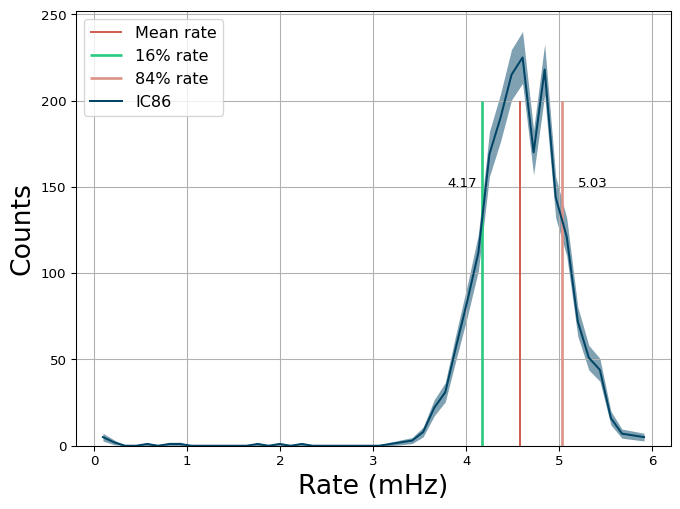

In [25]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=96)
h = hl.hist(rates, bins=50)
hl.plot1d(ax, h, errorbands=True, drawstyle='default', color='#004466', label="IC86")

ax.vlines(x=np.mean(rates),  ymin=0, ymax=200, color='#d06050', label="Mean rate")
ax.vlines(x=np.percentile(rates, 16),  ymin=0, ymax=200, color='#2aca80', label="16% rate", linewidth=2)
ax.vlines(x=np.percentile(rates, 84),  ymin=0, ymax=200, color='#dd9388', label="84% rate", linewidth=2)
ax.text(x=3.8,y=150, s="4.17")
ax.text(x=5.2,y=150, s="5.03")
ax.set_xlim(2, 7.2)
ax.set_ylim(0, 252)
ax.legend(loc=2, fontsize=12, frameon=True)
ax.grid()
ax.set_xlabel('Rate (mHz)', fontsize = 20)
ax.set_ylabel('Counts', fontsize = 20)

In [127]:
np.percentile(rates, 16), np.percentile(rates, 84)

(4.170038058547494, 5.030221825910278)

## Angular Error
<a id='angular-error'></a>

In [39]:
def angular_error_plot(true_energy, true_error, **kwargs):
    true_energy = true_energy
    true_error = true_error
    a = ana[-1]
    data, sig = a.data, a.sig
    if true_energy:
        energy_array = sig.true_energy
        xlab = r'$E_\mathrm{true}$ [GeV]'
    else:
        energy_array = sig.energy
        xlab = r'$E_\mathrm{reco}$ [GeV]'
    if true_error:
        error_array = sig.dpsi_deg
        ylab = r'$\Delta\Psi~[^\circ]$'
    else:
        error_array = sig.sigma_deg
        ylab = r'$\sigma~[^\circ]$'

    h = hl.hist_slide(
        (5,1),
        (energy_array, error_array),
        # E^-2 weighting
        sig.oneweight*sig.true_energy**-2,
        bins=(10**np.r_[0.0:5.0:.25], np.r_[0:180.01:1])
    )

    # normalize along the angular error axis
    h = h.normalize(1)
    # get 20%, 50%, and 80% quantiles
    h2 = h.contain(1, .16); h5 = h.contain(1, .5); h8 = h.contain(1, .84)
#     soft_colors = cy.plotting.soft_colors
    soft_colors = cy.plotting.mpl_colors_orig
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        fig, ax = plt.subplots()
    # plot quantiles, emphasize median
    color = soft_colors[0]
    hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
    hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')

    # trick to get the legend handles colored right
    # try testing what happens if you just do hl.fill_between(..., label='...')
    nans = [np.nan, np.nan]
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='84%')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='50%')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='16%')

    # labels etc
    fontsize=10
    ax.semilogx(); ax.set_xlabel(xlab, fontsize=fontsize)
    ax.set_ylabel(ylab, fontsize=fontsize)
    ax.set_xlim(h.bins[0][1], h.bins[0][-2]); ax.set_ylim(0)
    ax.legend(loc='upper right', fontsize=10); plt.tight_layout()
    # if self.savefigs:
    #     for ftype in ['pdf', 'png']:
    #         plt.savefig(self.savepath + \
    #                     f'GRECO_energy_vs_error_true_energy_{true_energy}_true_errors_{true_error}.{ftype}', 
    #                     dpi=self.dpi, bbox_inches='tight')

(0.0, 142.0)

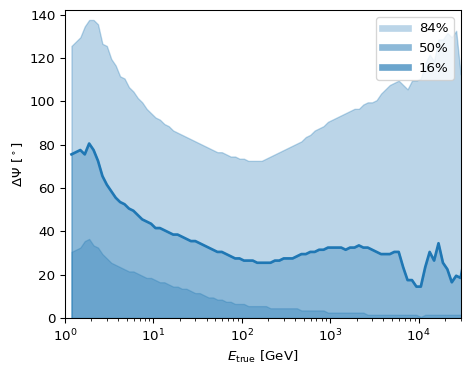

In [15]:
fig, ax = plt.subplots(figsize=(5,4), dpi=96)
angular_error_plot(True, True, ax=ax)
ax.set_xlim(1, 3e4)
ax.set_ylim(0, 142)

(0.0, 142.0)

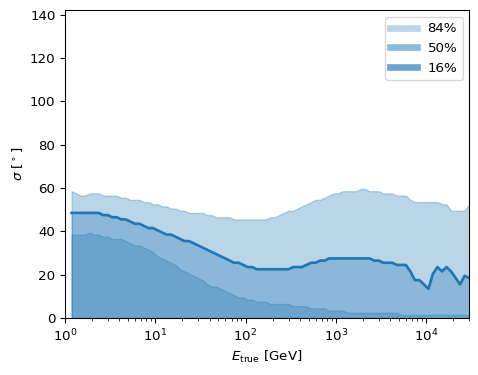

In [16]:
fig, ax = plt.subplots(figsize=(5,4), dpi=96)
angular_error_plot(True, False, ax=ax)
ax.set_xlim(1, 3e4)
ax.set_ylim(0, 142)

(0.0, 142.0)

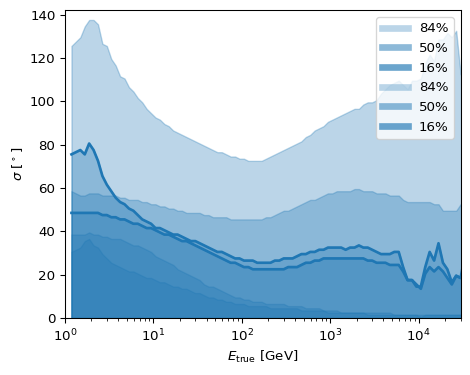

In [40]:
fig, ax = plt.subplots(figsize=(5,4), dpi=96)
angular_error_plot(True, True, ax=ax)
angular_error_plot(True, False, ax=ax)
ax.set_xlim(1, 3e4)
ax.set_ylim(0, 142)

# Time windows
<a id='time-windows'></a>

Text(0.5, 1.0, 'Size of Time Window')

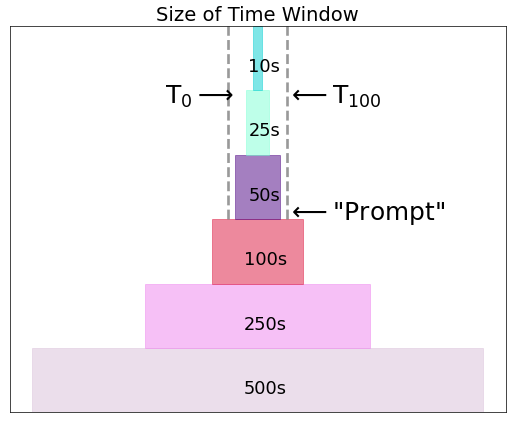

In [22]:
t100_start = -33
t100_end = +33
t_50 = (t100_start+t100_end)/2.
fig, ax = plt.subplots(figsize=(10,8), dpi=64)

l = 6.

tw=500
idx = 0
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='thistle')
ax.text(t_50-15, idx/l+0.05, '500s', fontsize=20)
tw=250
idx = 1
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='violet')
ax.text(t_50-15, idx/l+0.05, '250s', fontsize=20)
tw=100
idx = 2
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='crimson')
ax.text(t_50-15, idx/l+0.05, '100s', fontsize=20)
tw=50
idx = 3
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='indigo')
ax.text(t_50-10, idx/l+0.05, '50s', fontsize=20)
tw=25
idx = 4
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='aquamarine')
ax.text(t_50-10, idx/l+0.05, '25s', fontsize=20)
tw=10
idx = 5
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='darkturquoise')
ax.text(t_50-10, idx/l+0.05, '10s', fontsize=20)

ax.axvline(t100_start, 0.5, 1, linestyle='--', color='grey', alpha=0.8, linewidth=3)
ax.axvline(t100_end, 0.5, 1, linestyle='--', color='grey', alpha=0.8, linewidth=3)

ax.text(t100_start-70, 0.8, r'T$_{0}\longrightarrow$', fontsize=28)
ax.text(t100_end+0.011, 0.8, r'$\longleftarrow$T$_{100}$', fontsize=28)
ax.text(t100_end+0.012, 0.5, r'$\longleftarrow$"Prompt"', fontsize=28)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Size of Time Window', fontsize=22)

# Analysis
<a id='Analysis'></a>

## background scan
<a id='background-scan'></a>

### illustration
<a id='background-illustration'></a>

#### real grb GRB180423A

In [23]:
# real GRB
from scipy import sparse
file = DATA_DIR+"/plot/GRB180423A_batchSize1000_batchIndex0_tw500_backup.npz"
scan = sparse.load_npz(file)
maps = sparse.csr_matrix((0, hp.nside2npix(64)), dtype=float)
maps = sparse.vstack((maps, scan))

In [22]:
# 2,8,11,12,13,17,'23',28,

In [23]:
# np.min(ts_prior[ts_prior > 0])

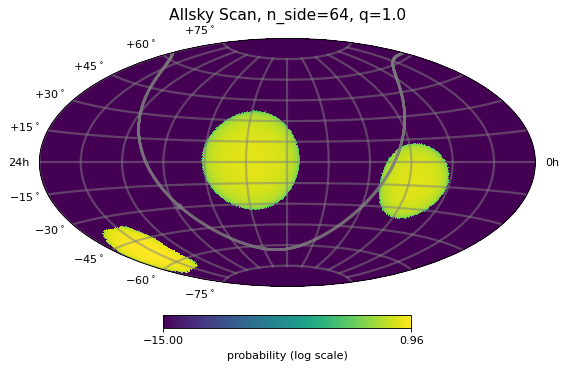

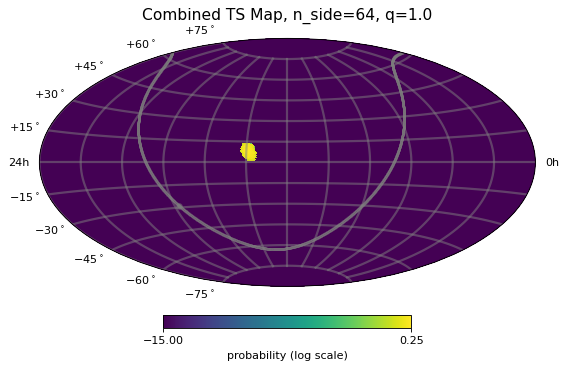

In [69]:
healpix = maps[23].toarray()[0]
q=1.
healpix[healpix < isf_healpix(healpix, q=q)] = 0
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-15)), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability (log scale)')
ax.set_title("Allsky Scan, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()

################################### log scale ####################################################

probs = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
probs = np.maximum(probs, 1e-15)
ts_norm = np.log(np.amax(probs))
ts_prior = healpix + 2*(np.log(probs) - ts_norm)
ts_prior = np.maximum(ts_prior, 1e-15)
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(np.maximum(ts_prior, 1e-15)), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability (log scale)')
ax.set_title("Combined TS Map, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()


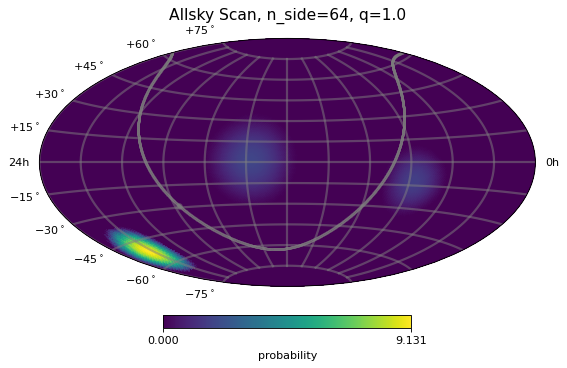

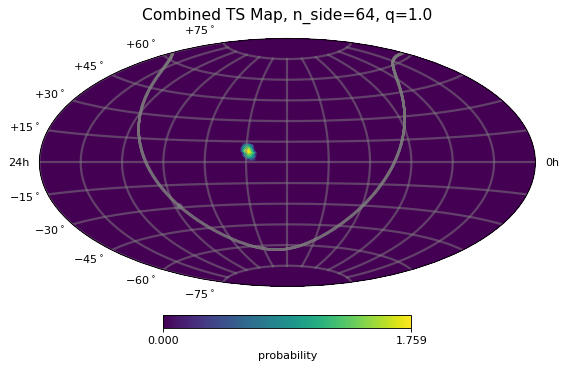

In [70]:
q=1.
healpix[healpix < isf_healpix(healpix, q=q)] = 0
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, healpix, 1e-15, n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability')
ax.set_title("Allsky Scan, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()


######################################### linear scale ##############################################

probs = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
probs = np.maximum(probs, 1e-15)
ts_norm = np.log(np.amax(probs))
ts_prior = healpix + 2*(np.log(probs) - ts_norm)
ts_prior = np.maximum(ts_prior, 1e-15)
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.maximum(ts_prior, 1e-15), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability')
ax.set_title("Combined TS Map, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()



#### fake grb GRB190611B

In [25]:
# real GRB
from scipy import sparse
file = DATA_DIR+"/plot/GRB180423A_batchSize1000_batchIndex0_tw500_backup.npz"
scan = sparse.load_npz(file)
maps = sparse.csr_matrix((0, hp.nside2npix(64)), dtype=float)
maps = sparse.vstack((maps, scan))

In [51]:
# 14, 20, '32', '64', '71', 

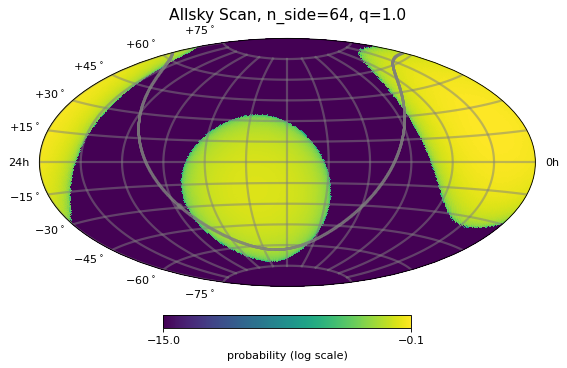

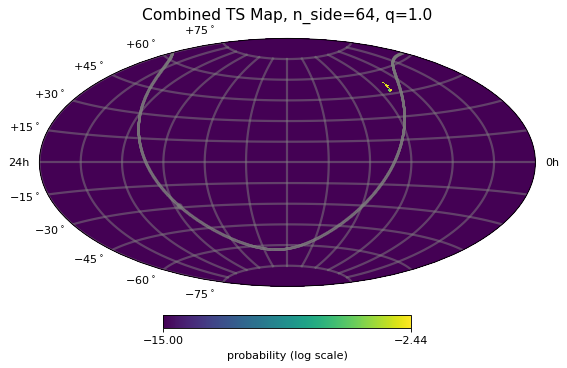

In [90]:
healpix = maps[71].toarray()[0]
q=1.
healpix[healpix < isf_healpix(healpix, q=q)] = 0
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-15)), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability (log scale)')
ax.set_title("Allsky Scan, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()

################################### log scale ####################################################

probs = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB190611B"))
probs = np.maximum(probs, 1e-15)
ts_norm = np.log(np.amax(probs))
ts_prior = healpix + 2*(np.log(probs) - ts_norm)
ts_prior = np.maximum(ts_prior, 1e-15)
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(np.maximum(ts_prior, 1e-15)), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability (log scale)')
ax.set_title("Combined TS Map, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()



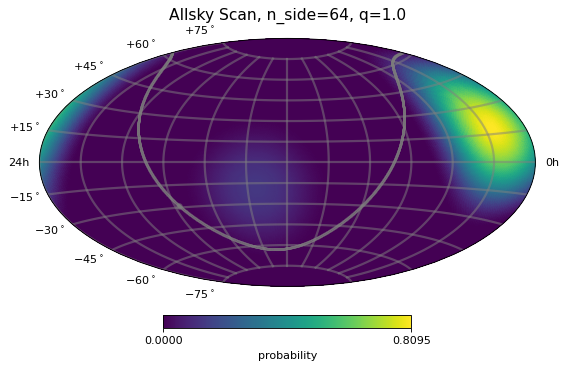

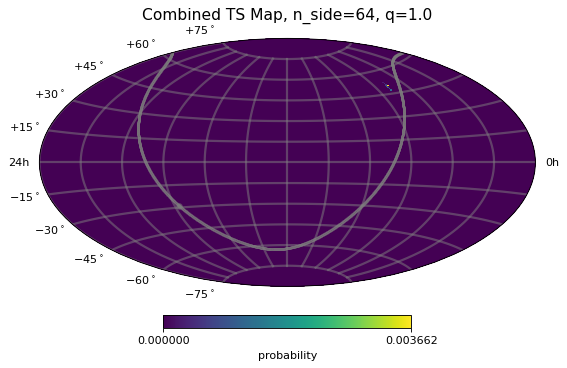

In [91]:
q=1.
healpix[healpix < isf_healpix(healpix, q=q)] = 0
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, healpix, 1e-15, n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability')
ax.set_title("Allsky Scan, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()


######################################### linear scale ##############################################

probs = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB190611B"))
probs = np.maximum(probs, 1e-15)
ts_norm = np.log(np.amax(probs))
ts_prior = healpix + 2*(np.log(probs) - ts_norm)
ts_prior = np.maximum(ts_prior, 1e-15)
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.maximum(ts_prior, 1e-15), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability')
ax.set_title("Combined TS Map, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()




### background TS distribution
<a id='background-TS-distribution'></a>

In [327]:
def plot_bg_TS(array, label, norm=True, ax=None, show=True, grid=False, chi2fit=False, chi2fitlable=False):
    """
    Plot TS distribution(s) and produce one plot
    
    Parameters
    ----------
    array : one 1-D numpy array OR a python list of 1-D numpy arrays
        If it has a shape of (number, ): then only one distribution
        If it is a list of length N: we expect N distributions in one plot
        
    label : str OR a list of strs
        Label(s) for each individual distribution
        
    norm : bool
        wether we should normalize the distribution
        
    ax : matplotlib axes object
        If there are a set of axes outside the function, passing them through
        
    show: bool
        True if there is no plt.show() outside this function call
        
    grid: bool
        Show grid or not
        
    chi2fit : bool
        Show chi2fit line or not
    chi2fitlable : bool
        Show chi2fit labels or not
    
    Returns
    -------
    N/A
    
    See also
    -------
    N/A
    """
    try: 
        _ = array.shape
        array = [array]
    except:
        pass
    if type(label) == str:
        label = [label]
    
    if ax is None:
        fig, ax = plt.subplots(dpi=120)
        
    for arr, lb in zip(array, label):
        bg = cy.dists.Chi2TSD(arr)
        h = bg.get_hist(bins=50)
        
        color = next(ax._get_lines.prop_cycler)['color']
        hl.plot1d(ax, h, crosses=True,
                label='{}'.format(lb),
                 color=color)
        if chi2fit:
            x = h.centers[0]
            norm = h.integrate().values
            if not chi2fitlable:
                ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', color=color)
            else:
                ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', color=color,
                        label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

    if show:
        ax.set_yscale('log')
        ax.set_xlabel(r'TS')
        ax.set_ylabel(r'number of trials')
        ax.legend()
        ax.grid(grid)
        plt.tight_layout()


In [328]:
# grb_name = "GRB180423A"    # real healpix example
# grb_name = "GRB190611B"    # fake healpix example
# ["GRB180423A", "GRB170527A", "GRB150716A"]
# ["GRB191203A", "GRB170921B"]  largeSU-GBM GRB, largeSU-nonGBM GRB

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'GRB180423A')

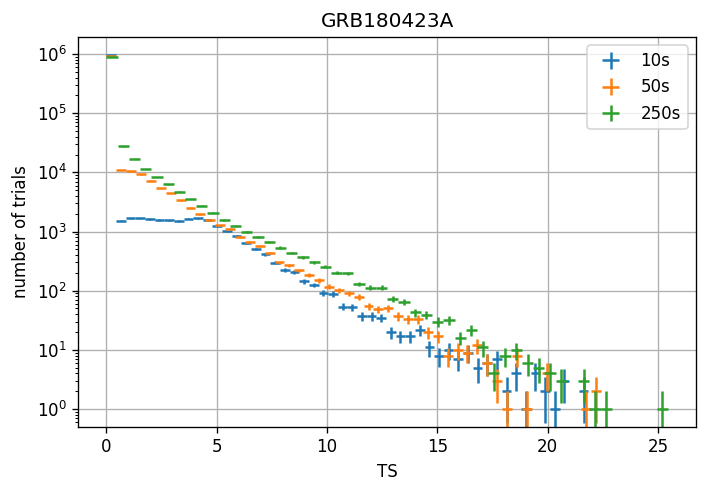

In [329]:
## real
grb_name = "GRB180423A"
files = glob(ANA_DIR+f"/allsky_scan/with_prior_background/tw*/{grb_name}*.npz")
files.sort(key=lambda x: int(x[x.find("_tw") + len("_tw"): x.find("_NTrial")]))
TSs = [sparse.load_npz(file).toarray()[0] for file in files]
indices = [0,2,4]
plot_bg_TS([TSs[i] for i in indices], 
           [['10s', '25s','50s','100s','250s','500s'][i] for i in indices], 
           grid=True,
          chi2fit=False)
plt.title(f"{grb_name}")

In [309]:
def custom_chi2(x, dof, loc, scale, norm):
    from scipy.stats import chi2
    c2 = chi2(dof, loc, scale)
    return norm*c2.pdf(x)

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


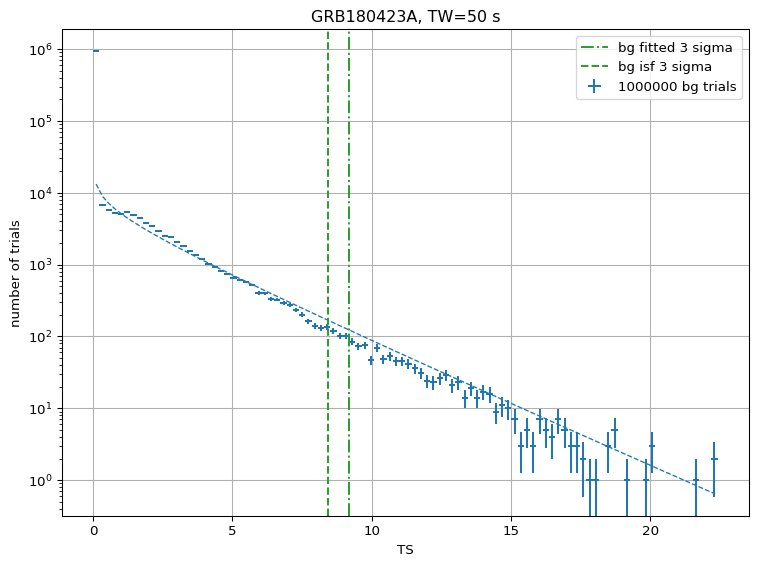

In [334]:
grb_name = "GRB180423A"
tw_in_second = 50

bg_files = glob(ANA_DIR+f"/allsky_scan/with_prior_background/tw{tw_in_second}/{grb_name}*.npz")
arr = np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files])
bg = cy.dists.Chi2TSD(arr)

fig, ax = plt.subplots(figsize=(8,6), dpi=96)
h = bg.get_hist(bins=100)
hl.plot1d(ax, h, crosses=True, label='{} bg trials'.format(bg.n_total))

x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', color='tab:blue')

ax.axvline(x=bg.isf_nsigma(3, fit=True), linestyle='-.', label='bg fitted 3 sigma', color='tab:green')
ax.axvline(x=bg.isf_nsigma(3, fit=False), linestyle='--', label='bg isf 3 sigma', color='tab:green')

ax.legend(loc="upper right")
ax.grid()
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.set_yscale('log')
ax.set_title(f"{grb_name}, TW={tw_in_second} s")
plt.tight_layout()

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'GRB170527A')

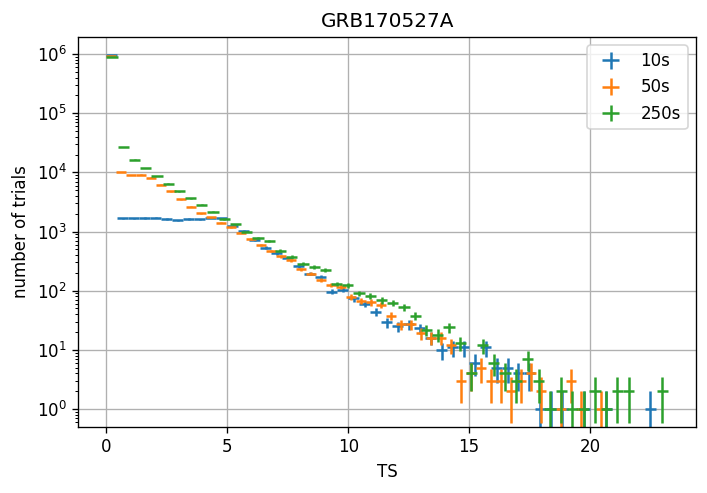

In [335]:
## ipn-gbm-grb
grb_name = "GRB170527A"
files = glob(ANA_DIR+f"/allsky_scan/with_prior_background/tw*/{grb_name}*.npz")
files.sort(key=lambda x: int(x[x.find("_tw") + len("_tw"): x.find("_NTrial")]))
TSs = [sparse.load_npz(file).toarray()[0] for file in files]
indices = [0,2,4]
plot_bg_TS([TSs[i] for i in indices], 
           [['10s', '25s','50s','100s','250s','500s'][i] for i in indices], 
           grid=True,
          chi2fit=False)
plt.title(f"{grb_name}")

Text(0.5, 1.0, 'GRB150716A')

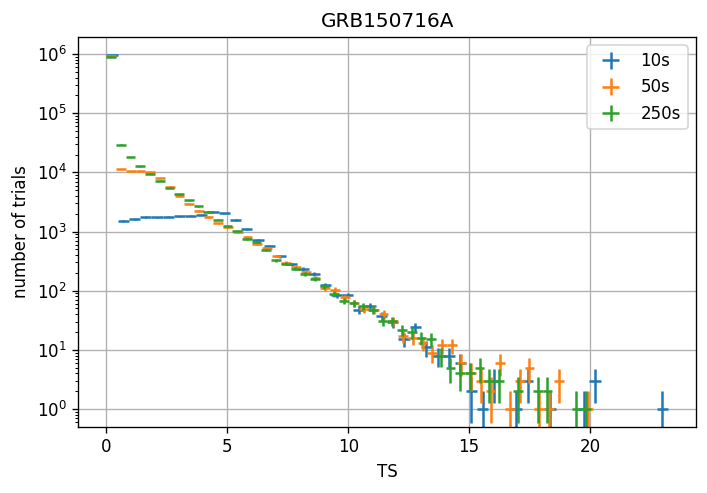

In [336]:
grb_name = "GRB150716A"
files = glob(ANA_DIR+f"/allsky_scan/with_prior_background/tw*/{grb_name}*.npz")
files.sort(key=lambda x: int(x[x.find("_tw") + len("_tw"): x.find("_NTrial")]))
TSs = [sparse.load_npz(file).toarray()[0] for file in files]
indices = [0,2,4]
plot_bg_TS([TSs[i] for i in indices], 
           [['10s', '25s','50s','100s','250s','500s'][i] for i in indices], 
           grid=True,
          chi2fit=False)
plt.title(f"{grb_name}")

Text(0.5, 1.0, 'GRB191203A')

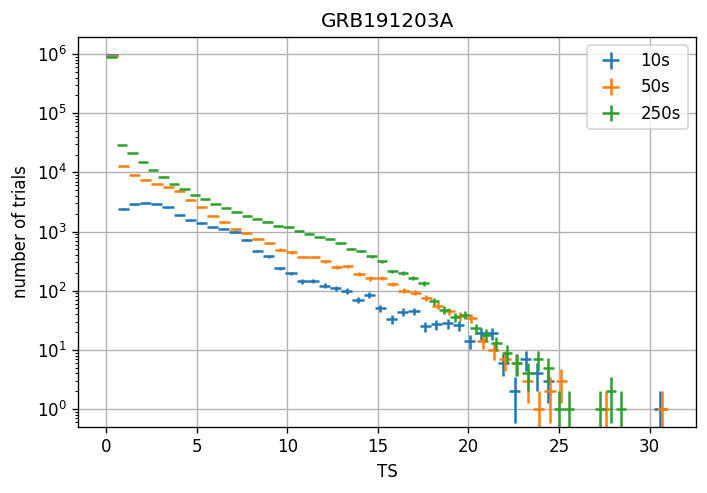

In [337]:
## real
grb_name = "GRB191203A"
files = glob(ANA_DIR+f"/allsky_scan/with_prior_background/tw*/{grb_name}*.npz")
files.sort(key=lambda x: int(x[x.find("_tw") + len("_tw"): x.find("_NTrial")]))
TSs = [sparse.load_npz(file).toarray()[0] for file in files]
indices = [0,2,4]
plot_bg_TS([TSs[i] for i in indices], 
           [['10s', '25s','50s','100s','250s','500s'][i] for i in indices], 
           grid=True,
          chi2fit=False)
plt.title(f"{grb_name}")

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'GRB170921B')

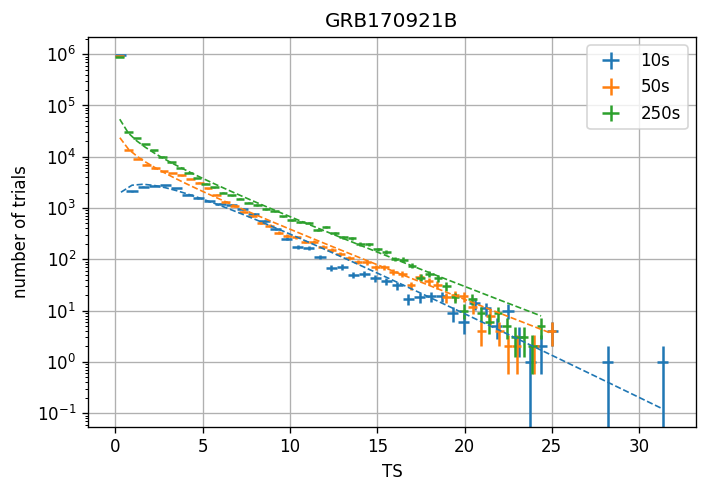

In [8]:
## real
grb_name = "GRB170921B"
files = glob(ANA_DIR+f"/allsky_scan/with_prior_background/tw*/{grb_name}*.npz")
files.sort(key=lambda x: int(x[x.find("_tw") + len("_tw"): x.find("_NTrial")]))
TSs = [sparse.load_npz(file).toarray()[0] for file in files]
indices = [0,2,4]
plot_bg_TS([TSs[i] for i in indices], 
           [['10s', '25s','50s','100s','250s','500s'][i] for i in indices], 
           grid=True,
          chi2fit=True)
plt.title(f"{grb_name}")

## signal injection 
<a id='signal-injection'></a>

In [175]:
### testing on jupyter ###
class args:
    # grb_name = "GRB180423A"    # real healpix example
    # grb_name = "GRB190415A"    # fake healpix example
    
    def __init__(self, 
                 grb_name="GRB160802A", # GRB140807A, GRB160802A
                 source_name="GRB160802A",
                 tw_in_second=500, 
                 ncpu=4, 
                 n_injs=np.round(np.r_[0:9.1:0.2], 2)):
        self.grb_name = grb_name
        self.source_name = source_name
        self.tw_in_second = tw_in_second
        self.ncpu = ncpu
        self.n_injs = n_injs
##########################
args = args()

In [176]:
np.r_[0.:9.2:1.0]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [177]:
n_injs = args.n_injs
# n_injs = [0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2,7.8, 8.4, 9. ]
n_injs = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]
sig = {}
for n_inj in n_injs:
    sig_files = glob(ANA_DIR+"/prior_injection/gamma_2.50/tw{}/{}/{}*{}.npy".format(
        args.tw_in_second, 
        args.grb_name, 
        args.grb_name,
        n_inj))
    sig[n_inj] = cy.utils.Arrays(np.ravel([np.load(sig_file) for sig_file in sig_files]))


In [178]:
trials = []
for n_inj in n_injs:
    tmp = sig[n_inj]
    tmp['ninj'] = np.repeat(n_inj, tmp.ns.size)
    trials.append(tmp)
allt = cy.utils.Arrays.concatenate(trials)
allt

Arrays(5000 items | columns: ninj, ns, ts)

In [179]:
ns_bins

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5])

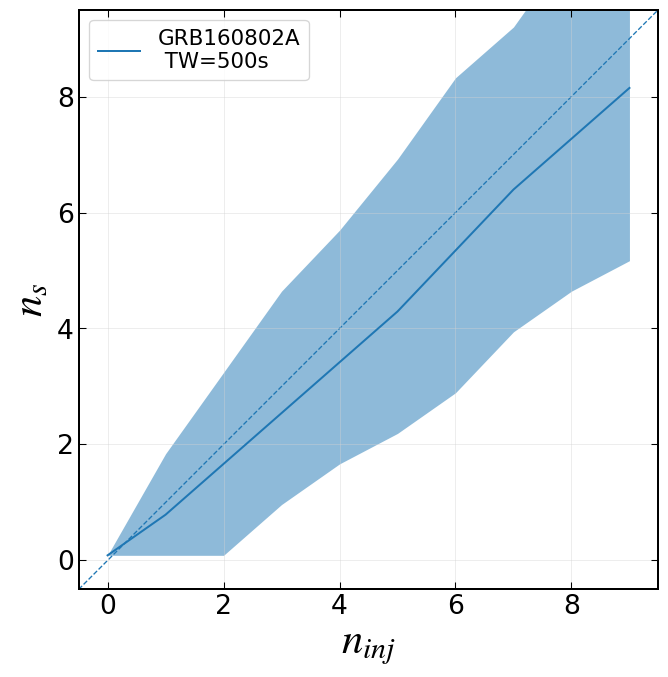

In [180]:
with mpl.rc_context(tmp_style):
    fig, ax = plt.subplots(figsize=(10,8), dpi=96)
    dns = np.mean(np.diff(n_injs))
    ns_bins = np.r_[n_injs - 0.5*dns, n_injs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    # h = hl.hist((allt.ninj, allt.ns), bins=(ns_bins, 100))
    #
    h = hl.hist_slide(
        (1,1),
        (allt.ninj, allt.ns),
        bins=(ns_bins, 100)
    )
    h = h.normalize(1)
    #
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default', label=f"{args.grb_name}\n TW={args.tw_in_second}s")
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')
    ax.set_xlabel('$n_{inj}$',fontsize=32)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_ylabel('$n_s$',fontsize=32)

In [19]:
src = cy.sources(
    ra=ra,
    dec=dec,
    deg=True,
    mjd=tw_start, 
    sigma_t=np.zeros_like(tw), 
    t_100=tw,  # in days
    prior=[hl.heal.HealHist(healpix)],
    name=args.grb_name
)
seed = abs(java_hash(src.name[0]+"_signal_batchIndex{}".format(args.batchIndex)))
sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                         ,src_tr=src
                                         ,llh_priors=[healpix]
                                         ,cut_n_sigma=5.) # src_tr is must for transient


In [20]:
def get_random(seed=None):
    """Get numpy RandomState."""
    if seed is None:
        return np.random
    elif isinstance(seed, np.random.RandomState):
        return seed
    else:
        return np.random.RandomState(seed)

random = get_random(seed)
##########################################
n_trials = args.batchNtrials
##########################################
BIG = 2**32
seeds = random.randint(BIG, size=n_trials)

trials = []
for sd in seeds:
    trial = sptr.get_one_trial(n_sig=args.n_inj, poisson=args.use_poisson, seed=sd)
    trials.append(trial)


In [21]:
trial = trials[0]

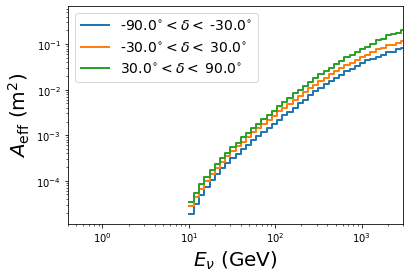

In [19]:
mc_greco = ana[0].sig[(ana[0].sig.true_energy > 10) & (ana[0].sig.true_energy < 10000)]
Aeffs = effective_area(mc=mc_greco, E_bins=np.logspace(1., 4., 51))
Aeff = Aeffs[1]

In [109]:
def plot_injected_event_energy_test():
    """
    IMPORTANT: this is a unfinished function
    can only be used to test GRB180423A
    no ability to choose correct Aeff at other declination
    """
    class args:
        grb_name = "GRB180423A"    # real healpix example
        # grb_name = "GRB190415A"    # fake healpix example
        n_inj = 1e6
        batchNtrials = 1
        tw_in_second = 100
        batchIndex = 0
        use_poisson = True
        ncpu = 4
    print("\n===== Loading no-healpix df =====\n")
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHeaplix.pkl")
    # realHealpix: df.gbm & df.hasHealpix
    # fakeHealpix: ~(df.gbm & df.hasHealpix)
    df.head()

    print("\n===== Loading healpix of {}=====\n".format(args.grb_name))   
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))

    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    print("\n...Done\n")
    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )
    seed = abs(java_hash(src.name[0]+"_signal_batchIndex{}".format(args.batchIndex)))
    sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                             ,src_tr=src
                                             ,llh_priors=[healpix]
                                             ,cut_n_sigma=5.) # src_tr is must for transient
    def get_random(seed=None):
        """Get numpy RandomState."""
        if seed is None:
            return np.random
        elif isinstance(seed, np.random.RandomState):
            return seed
        else:
            return np.random.RandomState(seed)

    random = get_random(seed)
    ##########################################
    n_trials = args.batchNtrials
    ##########################################
    BIG = 2**32
    seeds = random.randint(BIG, size=n_trials)

    trials = []
    for sd in seeds:
        trial = sptr.get_one_trial(n_sig=args.n_inj, poisson=args.use_poisson, seed=sd)
        trials.append(trial)
    trail = trials[0]
    mc_greco = ana[0].sig[(ana[0].sig.true_energy > 10) & (ana[0].sig.true_energy < 10000)]
    Aeffs = effective_area(mc=mc_greco, E_bins=np.logspace(1., 4., 51))
    Aeff = Aeffs[1]
    fig, ax = plt.subplots(figsize=(8,6), dpi=96)
    
    print(trials[0].evss[0])
    
    event_energy = 10**trials[0].evss[0][-1].log10energy
    h = hl.hist(event_energy, 
    #             weights=event_energy**2,
                weights=event_energy**2 / (np.diff(np.logspace(1., 4., 26))[np.digitize(event_energy, np.logspace(1., 4., 26))] * Aeff.get_values()[np.digitize(event_energy, Aeff.bins[0])] * args.tw_in_second), 
            bins=np.logspace(1., 4., 51))
    hl.plot1d(ax, h, label=f"TW={args.tw_in_second}, Ninj={len(event_energy)}")
    ax.set_xscale('log')
    ax.set_xlabel(r'$log_{10}(Energy)$', fontsize=16)
    ax.set_ylabel(r"$\frac{E^2}{A_{eff} * T} \frac{dCount}{dE}$", fontsize=16)
    ax.grid(True)
    ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.0, 0.95), fontsize=14)
    ax.set_title('Injected Events Energy'.format(len(df.t100)), fontsize=16, y=1.05)
    plt.show()
    


===== Loading no-healpix df =====


===== Loading healpix of GRB180423A=====


...Done

[Events(1000143 items | columns: azimuth, dec, idx, inj, log10energy, mjd, ra, sigma, sindec)]


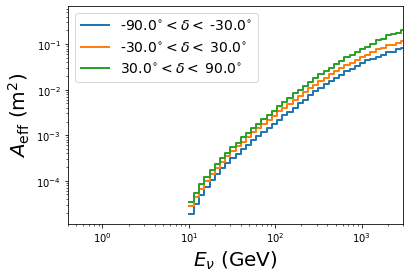

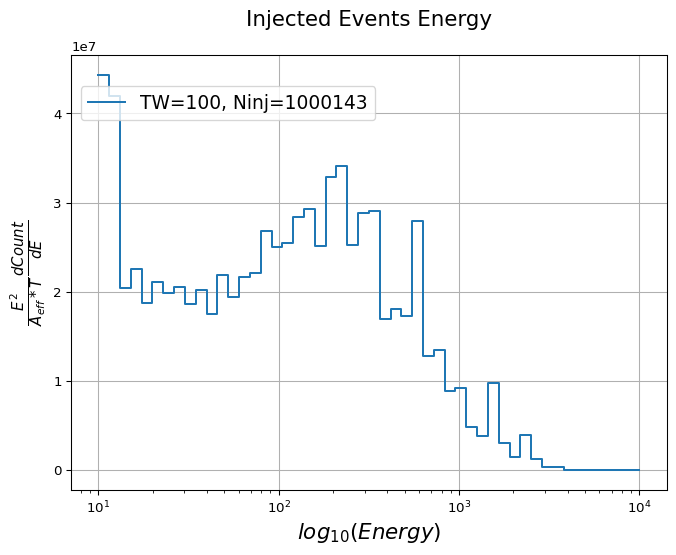

In [110]:
plot_injected_event_energy_test()